# Uploading and Preprocessing Data

In [ ]:
import pandas as pd
import os
from utils import *
from model import * 
from model_variations import * 
from my_statistics import *
from dynamic_IB_range import *

%load_ext autoreload
%autoreload 2


In [2]:
df_2 = utils.create_and_preprocess_trading_data("2024-01-01", "2024-11-20", True, 'data/data')

In [3]:
pandas_data_2 = df_2.to_pandas()

# Dynamic IB Range

### Data collection

In [ ]:
consolidation_data = collect_consolidation_data(pandas_data_2, df_2, window=32, range_threshold=4, filter_start_time="8:00:00", filter_end_time="15:59:00")
consolidation_data.insert(5, "breakout_time_pct", consolidation_data["breakout_time"].apply(time_str_to_percentage))

In [6]:
print(consolidation_data.shape)
consolidation_data.head()

(225, 14)


,date,direction,range_low,range_high,breakout_time,breakout_time_pct,breakout_price,breakout_distance,consolidation_range,consolidation_duration,std_dev,average_volume,average_volume_after_breakout,worked?
0,2024-01-04,down,4747.00,4751.00,14:04:00,75.833333,4746.50,0.5,4.00,0 days 00:39:00,0.869330,1064.394737,1500.0,True
1,2024-01-08,down,4736.00,4739.50,08:50:00,10.416667,4735.00,1.0,3.50,0 days 00:33:00,0.731630,463.968750,856.0,False
2,2024-01-08,up,4768.25,4771.75,13:48:00,72.500000,4773.25,1.5,3.50,0 days 00:33:00,0.615451,993.906250,2148.0,True
3,2024-01-09,down,4772.75,4776.50,09:18:00,16.250000,4772.25,0.5,3.75,0 days 00:34:00,0.890754,867.969697,838.0,True
4,2024-01-09,up,4794.00,4798.00,12:54:00,61.250000,4799.00,1.0,4.00,0 days 00:33:00,0.821676,1189.000000,2401.0,True


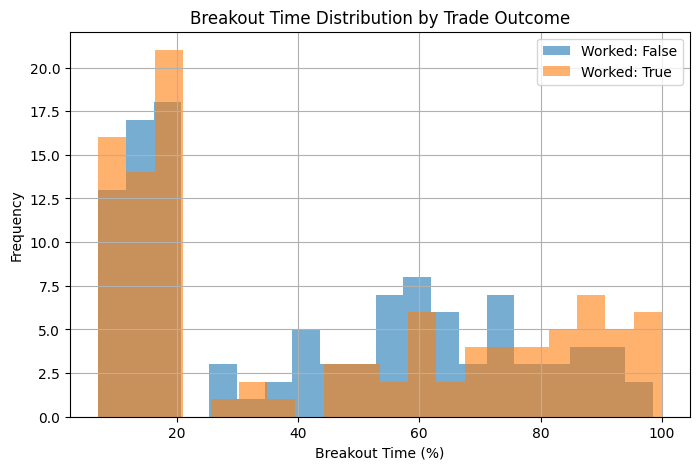

In [32]:
breakout_time_by_trade_outcome(consolidation_data)

Now I will collect consolidation data based on all possible combinations of the window and range_threshold parameters as defined below.

In [ ]:
windows = [12, 16, 20, 24, 28, 32, 36, 40, 44]
range_thresholds = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Generate all combinations of hyperparameters
hyperparam_combinations = itertools.product(range_thresholds, windows)

# Dictionary to store model_data DataFrames
model_data_dict = {}

for range_threshold, window in hyperparam_combinations:
    try:
        # Collect consolidation data
        consolidation_data = collect_consolidation_data(pandas_data_2, df_2, window=window, range_threshold=range_threshold,
                                                       filter_start_time="8:00:00", filter_end_time="15:59:00")

        # Check the collected data
        model_data = pd.DataFrame(consolidation_data)
        if model_data.empty:
            print(f"Warning: No data collected for window={window}, range_threshold={range_threshold}")
            continue  # Skip this iteration if no data

        model_data['breakout_time'] = pd.to_datetime(model_data['breakout_time'])

        # Create binary variable for whether the breakout is before or after 12 PM
        model_data['breakout_after_12pm'] = model_data['breakout_time'].dt.hour >= 12
        model_data['breakout_after_12pm'] = model_data['breakout_after_12pm'].astype(int)

        # Calculate features
        model_data['breakout_over_consolidation_volume_ratio'] = model_data['average_volume_after_breakout'] / model_data['average_volume']
        model_data['breakout_relative_size'] = model_data['breakout_distance'] / (model_data['range_high'] - model_data['range_low'])

        # Drop rows with missing target labels
        model_data = model_data.dropna(subset='worked?')
        model_data['worked?'] = model_data['worked?'].astype(int)

        # Select columns for training
        model_data = model_data[['average_volume_after_breakout', 'average_volume', 'breakout_over_consolidation_volume_ratio',
                                 'std_dev', 'breakout_relative_size', 'breakout_after_12pm', 'worked?']]

        # Create a key for each combination of hyperparameters
        param_key = (range_threshold, window)

        print("Data successfully processed for range_threshold ", range_threshold, "and window ", window)

        # Store the model_data DataFrame in the dictionary with the key
        model_data_dict[param_key] = model_data

    except Exception as e:
        print(f"Error processing combination {range_threshold}, {window}: {e}")
        continue

# Now model_data_dict contains a DataFrame for each combination of hyperparameters.


In [ ]:
# This code snippet simply saves all of the collected data on consolidations throughout the year in a folder inside of current directory

current_directory = os.getcwd()
folder_name = 'collect_consolidation_data_files'
os.makedirs(folder_name)

# Save each DataFrame inside the folder
for (range_threshold, window), model_data in model_data_dict.items():
    filename = os.path.join(folder_name, f'model_data_{range_threshold}_{window}.csv')
    model_data.to_csv(filename, index=False)

# Change the directory back to the original one
os.chdir(current_directory)

# Training the data

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
import itertools
import numpy as np

# Regularization hyperparameter (lambda) values as the inverse of regularization strength (C)
lambda_values = [0, 0.01, 0.03, 0.07, 0.1, 0.3, 0.7, 1, 3, 7, 10, 30, 70, 100]  # Example values for regularization strength

# Generate all combinations of hyperparameters (only lambda values in this case)
lambda_combinations = list(itertools.product(lambda_values))

# Store results
results = []

# Loop through the hyperparameter combinations
for (range_threshold, window), model_data in model_data_dict.items():
    for lambda_val in lambda_combinations:
        try:
            # Check if model_data is empty
            if model_data.empty:
                print(f"Warning: No data collected for window={window}, range_threshold={range_threshold}")
                continue  # Skip this iteration if no data

            # Split into features (X) and target (y)
            X = model_data[['average_volume_after_breakout', 'average_volume', 'breakout_over_consolidation_volume_ratio',
                            'std_dev', 'breakout_relative_size', 'breakout_after_12pm']]
            y = model_data['worked?']

            # Set up 5-fold cross-validation
            cv = KFold(n_splits=5, shuffle=True, random_state=42)

            # Lists to store metrics for each fold
            accuracies, precisions, recalls, f1_scores, roc_aucs, log_losses = [], [], [], [], [], []

            # 5-fold cross-validation
            for train_index, test_index in cv.split(X):
                X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
                y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

                # Scale the features
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train_cv)
                X_test_scaled = scaler.transform(X_test_cv)

                # Train Logistic Regression with regularization strength (lambda)
                log_reg = LogisticRegression(C=1/lambda_val[0], solver='liblinear', random_state=42)
                log_reg.fit(X_train_scaled, y_train_cv)

                # Evaluate the model on the testing fold
                y_pred = log_reg.predict(X_test_scaled)
                y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

                # Calculate evaluation metrics for the fold
                acc = accuracy_score(y_test_cv, y_pred)
                prec = precision_score(y_test_cv, y_pred)
                rec = recall_score(y_test_cv, y_pred)
                f1_val = f1_score(y_test_cv, y_pred)
                roc_val = roc_auc_score(y_test_cv, y_prob)
                ll = log_loss(y_test_cv, y_prob)

                # Append metrics for each fold
                accuracies.append(acc)
                precisions.append(prec)
                recalls.append(rec)
                f1_scores.append(f1_val)
                roc_aucs.append(roc_val)
                log_losses.append(ll)

            # Calculate the average metrics across all folds
            result = {
                'window': window,
                'range_threshold': range_threshold,
                'lambda': lambda_val[0],
                'accuracy': np.mean(accuracies),
                'precision': np.mean(precisions),
                'recall': np.mean(recalls),
                'f1_score': np.mean(f1_scores),
                'roc_auc': np.mean(roc_aucs),
                'log_loss': np.mean(log_losses),
                'sample_size': len(model_data)
            }

            print(result)
            results.append(result)

        except Exception as e:
            print(f"Error processing window={window}, range_threshold={range_threshold}, lambda={lambda_val[0]}: {e}")

# Convert results to DataFrame for easy analysis
final_results_df_logistic = pd.DataFrame(results)


In [ ]:
# final_results_df_logistic = pd.read_csv('final_results_df_logistic.csv')

In [43]:
print(final_results_df_logistic.shape)
precision_logistic = final_results_df_logistic[final_results_df_logistic['sample_size'] >= 300].sort_values(by='precision', ascending=False)
precision_logistic.head()

(1014, 10)


,window,range_threshold,lambda,accuracy,precision,recall,f1_score,roc_auc,log_loss,sample_size
514,36,6,3.00,0.579016,0.589478,0.707787,0.641765,0.542381,0.699236,532
513,36,6,1.00,0.575295,0.587610,0.696724,0.636177,0.541360,0.700302,532
507,36,6,0.01,0.573409,0.585788,0.696724,0.635127,0.541250,0.701006,532
508,36,6,0.03,0.573409,0.585788,0.696724,0.635127,0.541180,0.700990,532
509,36,6,0.07,0.573409,0.585788,0.696724,0.635127,0.541030,0.700959,532


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
import itertools
import numpy as np

# New Random Forest hyperparameters
max_depth = [4, 5, 6, 7]
min_samples_split = [5, 10, 15]
min_samples_leaf = [4]

# Generate all combinations of RF hyperparameters
rf_hyperparam_combinations = list(itertools.product(max_depth, min_samples_split, min_samples_leaf))

# Store results
results = []

# Loop through each (range_threshold, window) in model_data_dict
for (range_threshold, window), model_data in model_data_dict.items():
    if model_data.empty:
        print(f"Warning: No data collected for window={window}, range_threshold={range_threshold}")
        continue  # Skip if no data

    # Split into features (X) and target (y)
    X = model_data[['average_volume_after_breakout', 'average_volume', 
                    'breakout_over_consolidation_volume_ratio', 'std_dev', 
                    'breakout_relative_size', 'breakout_after_12pm']]
    y = model_data['worked?']

    # Loop over each combination of Random Forest hyperparameters
    for depth, split, leaf in rf_hyperparam_combinations:
        try:
            cv = KFold(n_splits=5, shuffle=True, random_state=42)

            # Lists for storing fold metrics
            accuracies, precisions, recalls, f1_scores, roc_aucs, log_losses = [], [], [], [], [], []

            # 5-fold cross-validation
            for train_index, test_index in cv.split(X):
                X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
                y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

                # Scale features to avoid data leakage
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train_cv)
                X_test_scaled = scaler.transform(X_test_cv)

                # Train RandomForestClassifier with current hyperparameters
                rf = RandomForestClassifier(max_depth=depth, 
                                            min_samples_split=split, 
                                            min_samples_leaf=leaf,
                                            random_state=42)
                rf.fit(X_train_scaled, y_train_cv)

                # Evaluate the model on the testing fold
                y_pred = rf.predict(X_test_scaled)
                y_prob = rf.predict_proba(X_test_scaled)[:, 1]

                # Compute metrics
                accuracies.append(accuracy_score(y_test_cv, y_pred))
                precisions.append(precision_score(y_test_cv, y_pred))
                recalls.append(recall_score(y_test_cv, y_pred))
                f1_scores.append(f1_score(y_test_cv, y_pred))
                roc_aucs.append(roc_auc_score(y_test_cv, y_prob))
                log_losses.append(log_loss(y_test_cv, y_prob))

            # Store average metrics over folds along with hyperparameters and data info
            result = {
                'window': window,
                'range_threshold': range_threshold,
                'max_depth': depth,
                'min_samples_split': split,
                'accuracy': np.mean(accuracies),
                'precision': np.mean(precisions),
                'recall': np.mean(recalls),
                'f1_score': np.mean(f1_scores),
                'roc_auc': np.mean(roc_aucs),
                'log_loss': np.mean(log_losses),
                'sample_size': len(model_data)
            }
            print(result)
            results.append(result)

        except Exception as e:
            print(f"Error processing window={window}, range_threshold={range_threshold}, "
                  f"max_depth={depth}, min_samples_split={split}, min_samples_leaf={leaf}: {e}")

# Convert results to DataFrame for easy analysis
final_results_df_random_forest = pd.DataFrame(results)


In [ ]:
# final_results_df_random_forest = pd.read_csv('final_results_df_random_forest.csv')

In [41]:
print(final_results_df_random_forest.shape)
precision_random_forest = final_results_df_random_forest[final_results_df_random_forest['sample_size'] >= 300].sort_values(by='precision', ascending=False)
precision_random_forest.head()

(936, 11)


,window,range_threshold,max_depth,min_samples_split,accuracy,precision,recall,f1_score,roc_auc,log_loss,sample_size
478,36,6,7,10,0.552724,0.573691,0.668879,0.615313,0.561975,0.700831,532
477,36,6,7,5,0.547117,0.571303,0.651149,0.606163,0.562599,0.700381,532
238,28,4,7,10,0.567205,0.570325,0.599142,0.581926,0.599938,0.698125,349
472,36,6,5,10,0.550838,0.569517,0.697931,0.624908,0.558882,0.697460,532
237,28,4,7,5,0.567246,0.569249,0.609567,0.586662,0.590764,0.700710,349


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = [3, 5, 7, 9, 11, 13, 15, 17, 19]  # Number of neighbors to use
weights = ['uniform', 'distance']  # Weighting function
metrics = ['euclidean']  # Distance metric

# Generate all combinations of hyperparameters
knn_hyperparam_combinations = list(itertools.product(n_neighbors, weights, metrics))


# Store results
results = []

# Loop through the hyperparameter combinations
for (range_threshold, window), model_data in model_data_dict.items():
    for n_neighbors_val, weight, metric in knn_hyperparam_combinations:
        try:
            # Check if model_data is empty
            if model_data.empty:
                print(f"Warning: No data collected for window={window}, range_threshold={range_threshold}")
                continue  # Skip this iteration if no data

            # Split into features (X) and target (y)
            X = model_data[['average_volume_after_breakout', 'average_volume', 'breakout_over_consolidation_volume_ratio',
                            'std_dev', 'breakout_relative_size', 'breakout_after_12pm']]
            y = model_data['worked?']

            cv = KFold(n_splits=5, shuffle=True, random_state=42)

            accuracies, precisions, recalls, f1_scores, roc_aucs, log_losses = [], [], [], [], [], []

            # 5-fold cross-validation
            for train_index, test_index in cv.split(X):
                X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
                y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]

                # Scale the features
                scaler = StandardScaler()
                X_train_scaled = scaler.fit_transform(X_train_cv)
                X_test_scaled = scaler.transform(X_test_cv)

                # Train k-NN Classifier
                knn = KNeighborsClassifier(n_neighbors=n_neighbors_val, weights=weight, metric=metric)
                knn.fit(X_train_scaled, y_train_cv)

                # Evaluate the model on the testing fold
                y_pred = knn.predict(X_test_scaled)
                y_prob = knn.predict_proba(X_test_scaled)[:, 1]

                acc = accuracy_score(y_test_cv, y_pred)
                prec = precision_score(y_test_cv, y_pred)
                rec = recall_score(y_test_cv, y_pred)
                f1_val = f1_score(y_test_cv, y_pred)
                roc_val = roc_auc_score(y_test_cv, y_prob)
                ll = log_loss(y_test_cv, y_prob)

                # Calculate evaluation metrics
                accuracies.append(acc)
                precisions.append(prec)
                recalls.append(rec)
                f1_scores.append(f1_val)
                roc_aucs.append(roc_val)
                log_losses.append(ll)

            result = {
                'window': window,
                'range_threshold': range_threshold,
                'n_neighbors': n_neighbors_val,
                'accuracy': np.mean(accuracies),
                'precision': np.mean(precisions),
                'recall': np.mean(recalls),
                'f1_score': np.mean(f1_scores),
                'roc_auc': np.mean(roc_aucs),
                'log_loss': np.mean(log_losses),
                'sample_size': len(model_data)
            }

            print(result)
            results.append(result)

        except Exception as e:
            print(f"Error processing window={window}, range_threshold={range_threshold}, n_neighbors={n_neighbors_val}, weights={weight}, metric={metric}: {e}")

# Convert results to DataFrame for easy analysis
final_results_df_knn = pd.DataFrame(results)


In [42]:
print(final_results_df_knn.shape)
precision_knn = final_results_df_knn[final_results_df_knn['sample_size'] >= 300].sort_values(by='precision', ascending=False)
precision_knn.iloc[0:5]

(1400, 10)


,window,range_threshold,n_neighbors,accuracy,precision,recall,f1_score,roc_auc,log_loss,sample_size
750,44,6,19,0.547272,0.585346,0.677823,0.619181,0.533086,0.719774,316
334,24,4,17,0.562767,0.582471,0.597402,0.585143,0.560594,0.708194,526
336,24,4,19,0.562731,0.581658,0.598549,0.585860,0.564067,0.702880,526
353,28,4,17,0.572961,0.581274,0.553774,0.565108,0.551177,0.723984,349
744,44,6,13,0.553423,0.580652,0.687674,0.624154,0.551801,0.714428,316


In [ ]:
# final_results_df_knn = pd.read_csv('final_results_df_knn.csv')